## Load Packages

In [3]:
# Link to Drive
from google.colab import drive
drive.mount('/content/drive')

# Connect to Earth Engine
#import ee
#ee.Authenticate()
#ee.Initialize()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
from glob import glob
import numpy as np
import pandas as pd
#!pip install shapely
!pip install geopandas
#!pip install xarray
!pip install rioxarray
!pip install geojson
#!pip install geemap
!pip install rasterstats

#import geemap
import geojson
import shapely as shp
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
#import gdal
import xarray as xr
import rioxarray as rioxr

## User-defined Functions

In [ ]:
# Function to Mask Clouds
def maskCloud(image):
  cloudMask = image.select(['pixel_qa']).bitwiseAnd(1<<5).eq(0)
  cloudShadowMask = image.select(['pixel_qa']).bitwiseAnd(1<<3).eq(0)
  final_mask = cloudMask.And(cloudShadowMask)
  return image.updateMask(final_mask)

In [ ]:
# Function to add water Index bands
def addIndex(image):
  ndwi = image.normalizedDifference(['green', 'nir']).rename(['ndwi'])
  # https://www.tandfonline.com/doi/abs/10.1080/01431169608948714
  
  mndwi = image.normalizedDifference(['green', 'swir1']).rename(['mndwi'])
  # https://www.tandfonline.com/doi/abs/10.1080/01431160600589179
  
  awei = image.expression("blue + 2.5*green - 1.5*(nir+swir1) - 0.25*swir2", {
    'blue': image.select(['blue']),
    'green': image.select(['green']),
    'nir': image.select(['nir']),
    'swir1': image.select(['swir1']),
    'swir2': image.select(['swir2'])
  }).rename(['awei'])
  # https://www.sciencedirect.com/science/article/pii/S0034425713002873
  
  wiFi = image.expression("1.7204 + 171*green +3*red - 70*nir - 45*swir1 - 71*swir2",{
    'green': image.select(['green']),
    'red': image.select(['red']),
    'nir': image.select(['nir']),
    'swir1': image.select(['swir1']),
    'swir2': image.select(['swir2'])
  }).rename(['wiFi'])
  # https://www.sciencedirect.com/science/article/abs/pii/S0034425715302753
  
  return image.addBands([ndwi, mndwi, awei, wiFi])


In [ ]:
# Function of ostu's method
def otsu(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum.divide(total)

    indices = ee.List.sequence(1, size)

    def iFunc(i):
      aCounts = counts.slice(0, 0, i) 
      aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
      aMeans = means.slice(0, 0, i)
      aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(),[0]).get([0]).divide(aCount)
      bCount = total.subtract(aCount)
      bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
      return aCount.multiply(aMean.subtract(mean).pow(2)) \
            .add(bCount.multiply(bMean.subtract(mean).pow(2)))

    # Compute between sum of squares, where each mean partitions the data
    bss = indices.map(iFunc)

    return means.sort(bss).get([-1])

In [ ]:
# Function of Otsu's Method
def thresholding(image):
  
  #waterIndex = index
  bands = ['ndwi', 'mndwi', 'awei', 'wiFi']

  #Compute the histogram of the NIR band. (the mean and variance are only FYI)
  hist_ndwi = image.select([bands[-1]]).reduceRegion(
      reducer = ee.Reducer.histogram().combine('mean', None, True).combine('variance', None, True),
      geometry = roi.getInfo(),
      scale = 30,
      maxPixels = 10e12,
      bestEffort = True)
  
  thrh_ndwi = otsu(hist_ndwi.get(bands[-1]+'_histogram'))

  watermask_ndwi = image.select([bands[-1]]).gt(thrh_ndwi).rename(['watermask_'+bands[-1]]).selfMask()
  
  #water = image.select([index]).lt(threshold)
  return image.addBands([watermask_ndwi]) \
              .clip(roi) \
              .copyProperties(image) \
              .set('system:time_start', ee.Date.fromYMD(image.get('year'), 12, 31))

In [ ]:
def thresholding2(image):
  #indices = ['ndwi', 'mndwi', 'awei', 'wiFi']
  #indices = ['wiFi']
  indices = waterIndices

  histograms = [image.select([i]).reduceRegion(
      reducer = ee.Reducer.histogram().combine('mean', None, True).combine('variance', None, True),
      geometry = roi.getInfo(),
      scale = 30,
      maxPixels = 10e12,
      bestEffort = True) for i in indices]

  thrhs = [otsu(h.get(i+'_histogram')) for h,i in zip(histograms,indices)]

  watermasks = [image.select([i]).gt(t).rename(['watermask_'+i]).selfMask() for i,t in zip(indices,thrhs)]

  #.addBands([watermasks[0], watermasks[1], watermasks[2], watermasks[3]]) 
  return image.addBands(watermasks)\
              .clip(roi) \
              .copyProperties(image) \
              .set('system:time_start', ee.Date.fromYMD(image.get('year'), 12, 31))

## Prepare ROI (Asia) for processing

### Load one-country parcels

In [5]:
# Load all parcels
os.chdir('/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/Coastline_parcels_polygon')
path_parcels = glob(os.path.join(os.getcwd(), '*.geojson'))[0]
parcels = gpd.read_file(path_parcels)
parcels.head()

,GID_0,NAME_0,xcentroid,ycentroid,rep_val,id,geometry
0,BGD,Bangladesh,89.623393,21.990277,55.806835,0,"MULTIPOLYGON (((89.31118 20.35796, 89.07910 21..."
1,BGD,Bangladesh,91.655673,21.423706,56.539689,1,"MULTIPOLYGON (((93.22541 23.10278, 93.12052 22..."
2,BGD,Bangladesh,91.256547,23.116165,57.186356,2,"MULTIPOLYGON (((93.23961 23.12663, 93.22541 23..."
3,CHN,China,109.037387,17.696821,63.367104,3,"MULTIPOLYGON (((108.86237 18.67709, 109.55282 ..."
4,CHN,China,108.746733,19.332447,64.039590,4,"MULTIPOLYGON (((108.89992 19.99171, 110.11844 ..."


In [6]:
parcelID = range(len(parcels))
parcelID

range(0, 266)

In [7]:
#parcels.to_file('parcels.geojson', driver='GeoJSON')
with open('parcels.geojson') as f:
  parcels_geojson = geojson.load(f)

### debris?

In [8]:
#parcels = (parcels.assign(xcentroid=lambda df: df['geometry'].centroid.x)
#       .assign(ycentroid=lambda df: df['geometry'].centroid.y)
#       .assign(rep_val=lambda df: df[['xcentroid', 'ycentroid']].mean(axis=1)) 
#       .sort_values(by=['GID_0', 'rep_val']))

# parcels = (parcels.assign(id = range(len(parcels))))
# parcels.to_file(os.path.join(os.getcwd(), 'parcels.geojson'), driver="GeoJSON")

In [9]:
#len(parcels_geojson['features'])

In [10]:
# List all countries
#countries = sorted(list(set(parcels['NAME_0'])))
#print(countries)

In [11]:
# Subset Parcels to one Country
#parcels_one_country = parcels[parcels['NAME_0']==countries[0]]
#parcels_one_country

## GEE: export data coverage /asia

In [ ]:
ROI = ee.FeatureCollection(parcels_geojson)

In [ ]:
# Load Landsat Archives
ls8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
        .filterDate('2013', '2020') \
        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
        .filterBounds(ROI) \
        .sort("system:time_start", True)
ls7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") \
      .filterDate('1999', '2020') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(ROI) \
      .sort("system:time_start", True)
ls5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") \
      .filterDate('1984', '2013') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(ROI) \
      .sort("system:time_start", True)
ls4 = ee.ImageCollection("LANDSAT/LT04/C01/T1_SR") \
      .filterDate('1984', '1994') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(ROI)\
      .sort("system:time_start", True)

# Merge Collections + Mask Cloud + Add water index bands
ls_all = ls8.merge(ls7).merge(ls5).merge(ls4)
ls_all = ls_all.sort('system:time_start', True).map(maskCloud).map(addIndex)

In [ ]:
# Count Observations at pixel level by year 
years = ee.List.sequence(1984, 2019)
counts = ee.ImageCollection.fromImages(
  years.map(lambda YEAR: 
            ls_all.select(['wiFi']).filter(ee.Filter.calendarRange(YEAR,YEAR,'year')).count().clip(ROI).set({'year':YEAR})))

In [ ]:
#Map = geemap.Map(center=(20, 110), zoom=3)
#Map.addLayer(ROI, {}, 'ROI')

#vis = {'palette':["#ebedef", "#f6ddcc", "#f8c471", "#f4d03f", "#58d68d", \
#                "#27ae60", "#1abc9c", "#3498db", "#2471a3", "#6c3483"], 'min':0, 'max':29}
#Map.addLayer(counts.filter(ee.Filter.eq('year',1987)), vis, '1987')
#Map.addLayer(counts.filter(ee.Filter.eq('year',2019)), vis, '2019')
#Map

In [ ]:
#img_count = counts.toBands()
#task_config = {
#    'description': 'data_coverage_asia_1km',
#    'fileNamePrefix': 'data_coverage_asia_1km',
#    'crs': 'EPSG:4326',
#    'scale': 1000,  
#    'region': ROI.geometry(),#.getInfo()['coordinates'],
#    'folder': 'myExportImage',
#    'skipEmptyTiles': True,
#    'fileFormat': 'GeoTIFF',
#    'maxPixels': 10e12
#    }
#task = ee.batch.Export.image.toDrive(img_count, **task_config)
#task.start() 
#task2 = ee.batch.Export.image.toDrive(img_count, **task_config)
#task2.start() 


In [ ]:
print(task.status())
print(task2.status())

{'state': 'COMPLETED', 'description': 'data_coverage_asia', 'creation_timestamp_ms': 1638907056438, 'update_timestamp_ms': 1638909341789, 'start_timestamp_ms': 1638907140885, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1F_SbqqdKupHKA64wB8jDTxegr-W-XyA_', 'https://drive.google.com/#folders/1F_SbqqdKupHKA64wB8jDTxegr-W-XyA_', 'https://drive.google.com/#folders/1F_SbqqdKupHKA64wB8jDTxegr-W-XyA_', 'https://drive.google.com/#folders/1F_SbqqdKupHKA64wB8jDTxegr-W-XyA_', 'https://drive.google.com/#folders/1F_SbqqdKupHKA64wB8jDTxegr-W-XyA_', 'https://drive.google.com/#folders/1F_SbqqdKupHKA64wB8jDTxegr-W-XyA_', 'https://drive.google.com/#folders/1F_SbqqdKupHKA64wB8jDTxegr-W-XyA_', 'https://drive.google.com/#folders/1F_SbqqdKupHKA64wB8jDTxegr-W-XyA_', 'https://drive.google.com/#folders/1F_SbqqdKupHKA64wB8jDTxegr-W-XyA_', 'https://drive.google.com/#folders/1F_SbqqdKupHKA64wB8jDTxegr-W-XyA_'], 'attempt': 1, 'id': 'NMMRUPAMGSTIMES332YBSKW3', 'name': 'project

## GEE: export water masks & data coverage /parcel

In [ ]:
# Define roi
roi = ee.Geometry(parcels_geojson['features'][parcelID[11]]['geometry'])
roi.getInfo()

{'coordinates': [[[117.343127, 21.713234],
   [115.604848, 24.620507],
   [114.259554, 24.219888],
   [115.30293, 21.028375],
   [117.343127, 21.713234]]],
 'type': 'Polygon'}

In [ ]:
# Load Landsat Archives
ls8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
        .filterDate('2013', '2020') \
        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
        .filterBounds(roi) \
        .sort("system:time_start", True)
ls7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") \
      .filterDate('1999', '2020') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(roi) \
      .sort("system:time_start", True)
ls5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") \
      .filterDate('1984', '2013') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(roi) \
      .sort("system:time_start", True)
ls4 = ee.ImageCollection("LANDSAT/LT04/C01/T1_SR") \
      .filterDate('1984', '1994') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(roi)\
      .sort("system:time_start", True)

# Merge Collections + Mask Cloud + Add water index bands
ls_all = ls8.merge(ls7).merge(ls5).merge(ls4)
ls_all = ls_all.sort('system:time_start', True).map(maskCloud).map(addIndex)

In [ ]:
# Temporally reduced at scale of one year
years = ee.List.sequence(1984, 2019)

ls_Treduced = ee.ImageCollection.fromImages(
    years.map(lambda YEAR: ls_all.filter(ee.Filter.calendarRange(YEAR, YEAR, 'year')) \
                          .median() \
                          .clip(roi) \
                          .set({'year': YEAR, 'system:time_start': ee.Date.fromYMD(YEAR, 12, 31)})))

In [ ]:
# Data Availability: annual counts of observations
#counts = ee.ImageCollection.fromImages(
#  years.map(lambda YEAR: 
#            ls_all.select(['wiFi'], ['count']).filter(ee.Filter.calendarRange(YEAR,YEAR,'year')).count().clip(roi).set({'year':YEAR, 'system:time_start': ee.Date.fromYMD(YEAR, 12, 31)})))
#print(counts.size().getInfo())

In [ ]:
# Filter out years where no data are available
# Add "bandlength" as new property
ls_filtered = ls_Treduced.map(lambda image: image.set('bandlength', image.bandNames().size()))
# Filter out the years where no data are available
ls_filtered = ls_filtered.filterMetadata('bandlength', 'not_equals', 0)

In [ ]:
# Apply Otsu
#waterIndices = ['ndwi', 'mndwi', 'awei', 'wiFi']
waterIndices = ['wiFi']

ls_wmsk = ls_filtered.map(thresholding2)
ls_wmsk = ls_wmsk.select(['watermask_'+i for i in waterIndices]).map(lambda image: image.toByte()) # Cast to uint-8bit 

print(ls_wmsk.size().getInfo())
print(ls_wmsk.first().bandNames().getInfo())
print(ls_wmsk.first().bandTypes().getInfo())

34
['watermask_wiFi']
{'watermask_wiFi': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}}


In [ ]:
# Join Two ImageCollections: water masks and counts
# https://gis.stackexchange.com/questions/327904/combine-two-image-collections-into-one-image-collection-earth-engine
# https://gis.stackexchange.com/questions/236551/combine-bands-from-two-image-collections

#filter = ee.Filter.equals(leftField = 'year', rightField = 'year')
#innerJoin = ee.ImageCollection(ee.Join.inner().apply(ls_wmsk, counts, filter))
#ls_joined = innerJoin.map(lambda feature: ee.Image.cat(feature.get('primary'), feature.get('secondary')))\
#                  .map(lambda image: image.toByte()) # Cast to uint-8bit

#print(ls_joined.size().getInfo())
#print(ls_joined.first().bandNames().getInfo())
#print(ls_joined.first().bandTypes().getInfo())

34
['watermask_wiFi', 'count']
{'count': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'watermask_wiFi': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}}


In [ ]:
#Map = geemap.Map(center=(20, 110), zoom=3)
#Map.addLayer(roi, {}, 'roi', False)
#Map.addLayer(ls_filtered.filter(ee.Filter.eq('year', 2019)), {'bands':['nir', 'red', 'green'], min:0, max:2550}, 'FCC')
#Map.addLayer(ls_wmsk.filter(ee.Filter.eq('year', 2019)).select(['watermask_mndwi']), {'palette':'blue'}, 'water mask mndwi')
#Map.addLayer(ls_wmsk.filter(ee.Filter.eq('year', 2019)).select(['watermask_wiFi']), {'palette':'orange'}, 'water mask awei')
#Map.addLayer(ls_joined.select(['watermask_wiFi']).filter(ee.Filter.eq('year', 2019)), {'palette':'pink'}, 'water mask wiFi')

#vis = {'palette':["#ebedef", "#f6ddcc", "#f8c471", "#f4d03f", "#58d68d", \
#                "#27ae60", "#1abc9c", "#3498db", "#2471a3", "#6c3483"], 'min':0, 'max':29}
#Map.addLayer(counts.filter(ee.Filter.eq('year',1987)), vis, '1987')
#Map.addLayer(counts.filter(ee.Filter.eq('year',2019)), vis, '2019')
#Map.addLayer(ls_joined.select(['count']).filter(ee.Filter.eq('year', 2019)), vis, '2019')
#Map

In [ ]:
img_wmsk = ls_wmsk.toBands()
#img_joined = ls_joined.toBands()
task_config = {
    'description': 'p100_maskx1',
    'fileNamePrefix': 'p100_maskx1',
    'crs': 'EPSG:4326',
    'scale': 30,  
    'region': roi.getInfo()['coordinates'],
    'folder': 'myExportImage',
    'skipEmptyTiles': True,
    'fileFormat': 'GeoTIFF',
    'maxPixels': 10e12
    }
task3 = ee.batch.Export.image.toDrive(img_wmsk, **task_config)
task3.start() 

In [ ]:
task3.status()

{'attempt': 1,
 'creation_timestamp_ms': 1639139674673,
 'description': 'p100_maskx1',
 'destination_uris': ['https://drive.google.com/#folders/1F_SbqqdKupHKA64wB8jDTxegr-W-XyA_',
  'https://drive.google.com/#folders/1F_SbqqdKupHKA64wB8jDTxegr-W-XyA_'],
 'id': 'N3VEC7CEWI5YRL56SYZXIGIW',
 'name': 'projects/earthengine-legacy/operations/N3VEC7CEWI5YRL56SYZXIGIW',
 'start_timestamp_ms': 1639139699978,
 'state': 'COMPLETED',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1639144166290}

## Post-processing in Python

### Compress Raster Size
reference: https://gis.stackexchange.com/questions/345883/how-to-decrease-raster-file-size

In [ ]:
wdir = '/content/drive/My Drive/myExportImage/parcels_msk_30m'
infn = glob(os.path.join(wdir,'*.tif'))
print(infn)
oufn = [i.split('.')[0]+'_rdc.tif' for i in infn]
print(oufn)

['/content/drive/My Drive/myExportImage/parcels_msk_30m/p100_maskx1-0000011264-0000000000.tif', '/content/drive/My Drive/myExportImage/parcels_msk_30m/p100_maskx1-0000000000-0000000000.tif']
['/content/drive/My Drive/myExportImage/parcels_msk_30m/p100_maskx1-0000011264-0000000000_rdc.tif', '/content/drive/My Drive/myExportImage/parcels_msk_30m/p100_maskx1-0000000000-0000000000_rdc.tif']


In [ ]:
# (PREDICTOR) 2 for integer;
ds = [gdal.Translate(o,i,creationOptions=["COMPRESS=LZW", "TILED=YES", "PREDICTOR=2"]) for o,i in zip(oufn,infn)]
ds = None

### Set up dataset for later processing

In [12]:
# Pair up Index and Years
keys = [str(i) for i in range(36)]
#years = pd.date_range(start='1984', end='2020', freq='Y')
years = [i for i in range(1984,2020)]
pair = dict([[i,j] for i,j in zip(keys, years)])
print(pair)

{'0': 1984, '1': 1985, '2': 1986, '3': 1987, '4': 1988, '5': 1989, '6': 1990, '7': 1991, '8': 1992, '9': 1993, '10': 1994, '11': 1995, '12': 1996, '13': 1997, '14': 1998, '15': 1999, '16': 2000, '17': 2001, '18': 2002, '19': 2003, '20': 2004, '21': 2005, '22': 2006, '23': 2007, '24': 2008, '25': 2009, '26': 2010, '27': 2011, '28': 2012, '29': 2013, '30': 2014, '31': 2015, '32': 2016, '33': 2017, '34': 2018, '35': 2019}


In [13]:
path_img = '/content/drive/My Drive/myExportImage/parcels_msk_30m/'
items = glob(os.path.join(path_img, '*rdc.tif'))
items

['/content/drive/My Drive/myExportImage/parcels_msk_30m/p100_maskx1-0000011264-0000000000_rdc.tif',
 '/content/drive/My Drive/myExportImage/parcels_msk_30m/p100_maskx1-0000000000-0000000000_rdc.tif']

In [14]:
elements = [rioxr.open_rasterio(i) for i in items]
#xda = [i.rename({'band':'time'}) for i in elements]
#xds = [i.to_dataset(name="watermask") for i in xda]

xda = elements[1].rename({'band':'time'})
xds = xda.to_dataset(name='watermask')
xds = xds.reindex(y = list(reversed(xds.y)))
xds

<xarray.Dataset>
Dimensions:      (time: 34, x: 11264, y: 11264)
Coordinates:
  * y            (y) float64 21.59 21.59 21.59 21.59 ... 24.62 24.62 24.62 24.62
  * time         (time) int64 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34
  * x            (x) float64 114.3 114.3 114.3 114.3 ... 117.3 117.3 117.3 117.3
    spatial_ref  int64 0
Data variables:
    watermask    (time, y, x) uint8 ...

In [15]:
# Get the index of loaded image
imgID = [i.split('_')[0] for i in xda.attrs['long_name']]
print(imgID)

# Get years based on index
t = [pair[i] for i in imgID]
print(t)

['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35']
[1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


In [16]:
# Replace "index" coordinates with "year" coordinates
xds.coords['time'] = np.array(t)
xds

<xarray.Dataset>
Dimensions:      (time: 34, x: 11264, y: 11264)
Coordinates:
  * y            (y) float64 21.59 21.59 21.59 21.59 ... 24.62 24.62 24.62 24.62
  * time         (time) int64 1986 1987 1988 1989 1990 ... 2016 2017 2018 2019
  * x            (x) float64 114.3 114.3 114.3 114.3 ... 117.3 117.3 117.3 117.3
    spatial_ref  int64 0
Data variables:
    watermask    (time, y, x) uint8 ...

In [17]:
# Map
#xds.watermask.sel(time=2019).plot()
#xds.watermask.plot(robust=True, col="time", col_wrap=3)

In [18]:
# Write Raster
#xds.rio.to_raster(os.path.join(path_img, 'p100_mask_tidy.tif'))

## Annual Water Info -> Attributes of each pond

### Load Ponds at Country Level

In [19]:
# Load Pond layer at Country Level
path_ponds = '/content/drive/My Drive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/Aquaculture_ponds_Asian_coast_2019/ponds_by_country/pond_2019_China.gpkg'
# Load Ponds of one country
ponds_chn = gpd.read_file(path_ponds)
ponds_chn.head()

,id,index_right,GID_0,NAME_0,geometry
0,88102,2,CHN,China,"MULTIPOLYGON (((107.83880 21.64298, 107.83958 ..."
1,88108,2,CHN,China,"MULTIPOLYGON (((107.84574 21.64895, 107.84596 ..."
2,88115,2,CHN,China,"MULTIPOLYGON (((107.86251 21.61913, 107.86251 ..."
3,88323,2,CHN,China,"MULTIPOLYGON (((107.87904 21.63030, 107.87904 ..."
4,88326,2,CHN,China,"MULTIPOLYGON (((107.88012 21.62934, 107.88030 ..."


### Subset Ponds to Parcel Level

In [20]:
ponds_sub = ponds_chn[ponds_chn.geometry.within(parcels[parcels['id']==parcelID[11]].geometry.unary_union)]
ponds_sub

,id,index_right,GID_0,NAME_0,geometry
831974,885556,2,CHN,China,"MULTIPOLYGON (((115.85321 23.41926, 115.85321 ..."
831975,885557,2,CHN,China,"MULTIPOLYGON (((115.85482 23.42285, 115.85482 ..."
831976,885558,2,CHN,China,"MULTIPOLYGON (((115.85608 23.41037, 115.85653 ..."
831977,885559,2,CHN,China,"MULTIPOLYGON (((115.85707 23.41225, 115.85734 ..."
831978,885560,2,CHN,China,"MULTIPOLYGON (((115.85815 23.41046, 115.85815 ..."
...,...,...,...,...,...
885710,941218,2,CHN,China,"MULTIPOLYGON (((114.68297 22.92878, 114.68297 ..."
885712,941220,2,CHN,China,"MULTIPOLYGON (((114.68701 22.91782, 114.68710 ..."
885714,941222,2,CHN,China,"MULTIPOLYGON (((114.68836 22.91414, 114.68863 ..."
885748,941259,2,CHN,China,"MULTIPOLYGON (((114.74747 22.73456, 114.74801 ..."


### Test on 1 pond

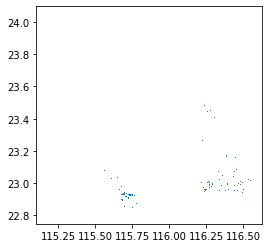

In [ ]:
ponds_sub[7388:15392].plot()

In [ ]:
ponds_test = ponds_sub.iloc[15391:15392]
ponds_test

,id,index_right,GID_0,NAME_0,geometry
847508,901456,2,CHN,China,"MULTIPOLYGON (((115.79877 22.80957, 115.79895 ..."


In [ ]:
ponds_test = (ponds_test.assign(mean19 = lambda gdf: float(xds.watermask.sel(time=2019).rio.clip(geometries = gdf.geometry, crs = 4326, all_touched=True).mean())))
ponds_test

,id,index_right,GID_0,NAME_0,geometry,mean19
847508,901456,2,CHN,China,"MULTIPOLYGON (((115.79877 22.80957, 115.79895 ...",0.333333


In [ ]:
#xds.watermask.sel(time=2019).rio.clip(geometries = ponds_test.geometry, crs = 4326, all_touched=True)
#float(cropped.mean())

### Test on 2 ponds: Iterate over ponds for a specific year!

In [ ]:
# Option.A: Iterate over ponds for a specific year!
ponds_test2 = ponds_sub.iloc[15390:15392]
ponds_test2

,id,index_right,GID_0,NAME_0,geometry
847507,901455,2,CHN,China,"MULTIPOLYGON (((115.79877 22.96507, 115.79877 ..."
847508,901456,2,CHN,China,"MULTIPOLYGON (((115.79877 22.80957, 115.79895 ..."


In [ ]:
# Function to get pixel value by polygon
def getWaterCover(pond_index):
  wc_xda = xds.watermask.sel(time=2019).rio.clip(geometries = ponds_test2.iloc[pond_index].geometry, crs = 4326, all_touched=True)
  wc_mean = wc_xda.mean()
  wc_scaled = int(float(wc_mean)*100)
  return wc_scaled

In [ ]:
#mean19 = [int(float(xds.watermask.sel(time=2019).rio.clip(geometries = ponds_test2.iloc[i].geometry, crs = 4326, all_touched=True).mean())*100) for i in range(len(ponds_test2))]
mean19 = [getWaterCover(i) for i in range(len(ponds_test2))]
mean19

/usr/local/lib/python3.7/dist-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
/usr/local/lib/python3.7/dist-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):


[100, 33]

In [ ]:
ponds_test2 = ponds_test2.assign(mean2019 = mean19)
ponds_test2

,id,index_right,GID_0,NAME_0,geometry,mean2019
847507,901455,2,CHN,China,"MULTIPOLYGON (((115.79877 22.96507, 115.79877 ...",100
847508,901456,2,CHN,China,"MULTIPOLYGON (((115.79877 22.80957, 115.79895 ...",33


In [ ]:
# Apply list comprehension in pandas dataframe: didn't work in my case!
#ponds_test2['mean19'] = ponds_test2.apply(lambda row: int(float(xds.watermask.sel(time=2019).rio.clip(geometries = row.geometry, crs = 4326, all_touched=True).mean())*100))

### Test on 2 ponds: Iterate over years

In [ ]:
ponds_test3 = ponds_sub.iloc[15390:15392]
ponds_test3

,id,index_right,GID_0,NAME_0,geometry
847507,901455,2,CHN,China,"MULTIPOLYGON (((115.79877 22.96507, 115.79877 ..."
847508,901456,2,CHN,China,"MULTIPOLYGON (((115.79877 22.80957, 115.79895 ..."


In [ ]:
# Function to get pixel value by polygon
def getWaterCover2(year, pond_index):
  wc_xda = xds.watermask.sel(time=year).rio.clip(geometries = ponds_test3.iloc[pond_index].geometry, crs = 4326, all_touched=True)
  wc_mean = wc_xda.mean()
  wc_scaled = int(float(wc_mean)*100)
  return wc_scaled

In [ ]:
#meanXX = [getWaterCover2(y, i) for y in t[-2:] for i in range(len(ponds_test3))]
#meanXX = [getWaterCover2(y,i) for y,i in zip(t[-2:], range(len(ponds_test3)))]
meanXX = [[getWaterCover2(y,i) for i in range(len(ponds_test3))] for y in t]
meanXX

/usr/local/lib/python3.7/dist-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
/usr/local/lib/python3.7/dist-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
/usr/local/lib/python3.7/dist-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
/usr/local/lib/python3.7/dist-packages/rasterio/features.py:284: ShapelyDeprecationWarning: It

[[0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 41],
 [100, 41],
 [100, 41],
 [100, 41],
 [100, 41],
 [100, 41],
 [100, 41],
 [100, 33],
 [100, 41],
 [100, 41],
 [100, 25],
 [100, 41],
 [100, 41],
 [100, 41],
 [100, 41],
 [0, 41],
 [100, 33],
 [100, 41],
 [0, 41],
 [0, 41],
 [100, 41],
 [100, 50],
 [0, 41],
 [100, 41],
 [100, 33],
 [100, 33],
 [100, 41],
 [100, 33]]

In [ ]:
meanXX[-1]

[100, 33]

In [ ]:
newcols = ['mean_'+str(y) for y in t]
print(newcols)
print(len(newcols))

['mean_1986', 'mean_1987', 'mean_1988', 'mean_1989', 'mean_1990', 'mean_1991', 'mean_1992', 'mean_1993', 'mean_1994', 'mean_1995', 'mean_1996', 'mean_1997', 'mean_1998', 'mean_1999', 'mean_2000', 'mean_2001', 'mean_2002', 'mean_2003', 'mean_2004', 'mean_2005', 'mean_2006', 'mean_2007', 'mean_2008', 'mean_2009', 'mean_2010', 'mean_2011', 'mean_2012', 'mean_2013', 'mean_2014', 'mean_2015', 'mean_2016', 'mean_2017', 'mean_2018', 'mean_2019']
34


In [ ]:
#ponds_test3_reindexed = ponds_test3.reindex(columns=ponds_test3.columns.tolist() + newcols)
#ponds_test3_reindexed

In [ ]:
#ponds_test3_reindexed = ponds_test3.assign(mean19 = meanXX[-1])
#ponds_test3_reindexed

### Test on 2 Ponds: Rasterstats

In [21]:
from rasterstats import zonal_stats

In [56]:
ponds_test4 = ponds_sub.iloc[15370:15390]
ponds_test4

,id,index_right,GID_0,NAME_0,geometry
847487,901434,2,CHN,China,"MULTIPOLYGON (((115.79464 22.82799, 115.79464 ..."
847488,901435,2,CHN,China,"MULTIPOLYGON (((115.79500 23.39995, 115.79518 ..."
847489,901436,2,CHN,China,"MULTIPOLYGON (((115.79545 22.82718, 115.79554 ..."
847490,901437,2,CHN,China,"MULTIPOLYGON (((115.79536 22.93309, 115.79571 ..."
847491,901438,2,CHN,China,"MULTIPOLYGON (((115.79580 22.82790, 115.79598 ..."
847492,901439,2,CHN,China,"MULTIPOLYGON (((115.79589 22.82646, 115.79607 ..."
847493,901440,2,CHN,China,"MULTIPOLYGON (((115.79643 22.90785, 115.79652 ..."
847494,901441,2,CHN,China,"MULTIPOLYGON (((115.79652 22.82781, 115.79679 ..."
847495,901442,2,CHN,China,"MULTIPOLYGON (((115.79670 22.92644, 115.79688 ..."
847496,901443,2,CHN,China,"MULTIPOLYGON (((115.79661 22.82709, 115.79715 ..."


In [23]:
xda_test = xds.sel(time=2019).to_array()
xda_test

<xarray.DataArray (variable: 1, y: 11264, x: 11264)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)
Coordinates:
  * y            (y) float64 21.59 21.59 21.59 21.59 ... 24.62 24.62 24.62 24.62
    time         int64 2019
  * x            (x) float64 114.3 114.3 114.3 114.3 ... 117.3 117.3 117.3 117.3
    spatial_ref  int64 0
  * variable     (variable) <U9 'watermask'

***For `zonal_stats` to work, make sure that*** <br>
* `array` is a 2D array;

* `transform` is written in this form:
1. top left easting or X coordinate
2. West-East pixel resolution
3. rotation (typically 0 if image is "north up")
4. top left northing or Y coordinate
5. rotation, (typically 0 if image is "north up")
6. North-South pixel resolution (typically -1 * W-E resolution)



In [74]:
# Convert DataArray to numpy array
# https://stackoverflow.com/questions/55132416/converting-dataarray-into-numpy-array
array = xda_test.values[0]
array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [72]:
# Get "Affine transform"
# https://github.com/perrygeo/python-rasterstats/blob/master/docs/notebooks/Integrating%20with%20GeoPandas%20and%20Numpy.ipynb

transform = xda_test.rio.transform()
we_pr, rotation, x, ns_pr, y = transform[0], transform[1], transform[2], transform[4], transform[5]
transform = [x, we_pr, rotation, y, rotation, ns_pr]
#transform = [114.25950576454272, 0.00026949458523585647, 0.0, 21.58543829905116, 0.0, -0.00026949458523585647]
transform

[114.25950576454272,
 0.00026949458523585647,
 0.0,
 21.58543829905116,
 0.0,
 -0.00026949458523585647]

In [73]:
zonstats = zonal_stats(ponds_test4, array, transform=transform, categorical=True) #  
zonstats

/usr/local/lib/python3.7/dist-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/usr/local/lib/python3.7/dist-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/usr/local/lib/python3.7/dist-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/usr/local/lib/python3.7/dist-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/usr/local/lib/python3.7/dist-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/usr/local/lib/python3.7/dist-

[{25: 12},
 {25: 1},
 {25: 2},
 {25: 4},
 {25: 3},
 {25: 2},
 {25: 2},
 {25: 2},
 {25: 7},
 {25: 5},
 {25: 4},
 {25: 2},
 {},
 {25: 3},
 {},
 {25: 2},
 {25: 2},
 {25: 3},
 {},
 {}]

## Export GEE Map to html / image